In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ggplot import *
import itertools
from random import shuffle

%matplotlib inline

In [34]:
from sklearn.base import BaseEstimator, ClassifierMixin

from sklearn.linear_model import LinearRegression, Lasso, ElasticNet, BayesianRidge, ARDRegression
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor, AdaBoostRegressor, BaggingRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor

from sklearn.metrics import make_scorer        
from sklearn.grid_search import ParameterGrid

# 1. Understand Data

1. Read data & base information
2. Distributions
3. Target variable
4. Corellation matrix

## 1.1 Read data & base information

In [3]:
train = pd.read_csv('train.csv')
#test = pd.read_csv('test.csv')

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10886 entries, 0 to 10885
Data columns (total 12 columns):
datetime      10886 non-null object
season        10886 non-null int64
holiday       10886 non-null int64
workingday    10886 non-null int64
weather       10886 non-null int64
temp          10886 non-null float64
atemp         10886 non-null float64
humidity      10886 non-null int64
windspeed     10886 non-null float64
casual        10886 non-null int64
registered    10886 non-null int64
count         10886 non-null int64
dtypes: float64(3), int64(8), object(1)
memory usage: 1.1+ MB


1. We have **10 886** observations and **12** features.
2. We don't have missing value.
3. Most value is integer, few of them float and object (should be a date).


### Check [Five-number summary](https://en.wikipedia.org/wiki/Five-number_summary)

In [5]:
train.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000


1. **count** is target value and it changes between from **1** to **977**.
2. **registered** and **casual** there's only in training set - but we can use also like target value.
3. **holiday**, **workingday** is a binary variables (0 or 1).
4. **season**, **weather** - categorical variable (1,2,3 or 4).
5. rest features is numerical variables.

**Let's try to visualise distribution each features.**

## 1.2 Distributions

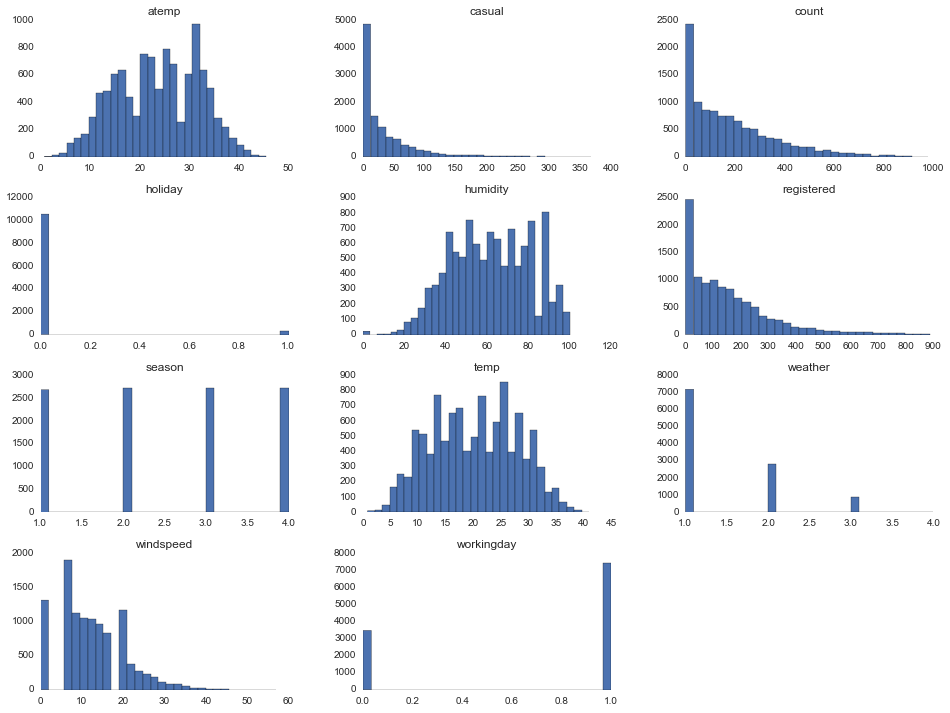

In [6]:
train.hist(figsize=(16,12),bins=30)
plt.show()

1. **atemp** have some spikes on 10,20,30 (more rounded number).
2. **count** the most value is in the first bucket and have big tail on the second right. We can try transform using log (it can be helpful).
3. **weather** looks like corelated to count of rows.
4. ** season** all buckets look comparatively equal.
5. **windspeed** there're some missing buckets between 0 and 10, and 19. Maybe it's some problem with data (human error).

## 1.3 Target variable
- we should predict **count**
- but **count** is also summary **registered** and **casual**
- also do log transformation (for count and registered/casual) and predict it.

## 1.4 Correlation matrix

**Let's to see correlation matrix**

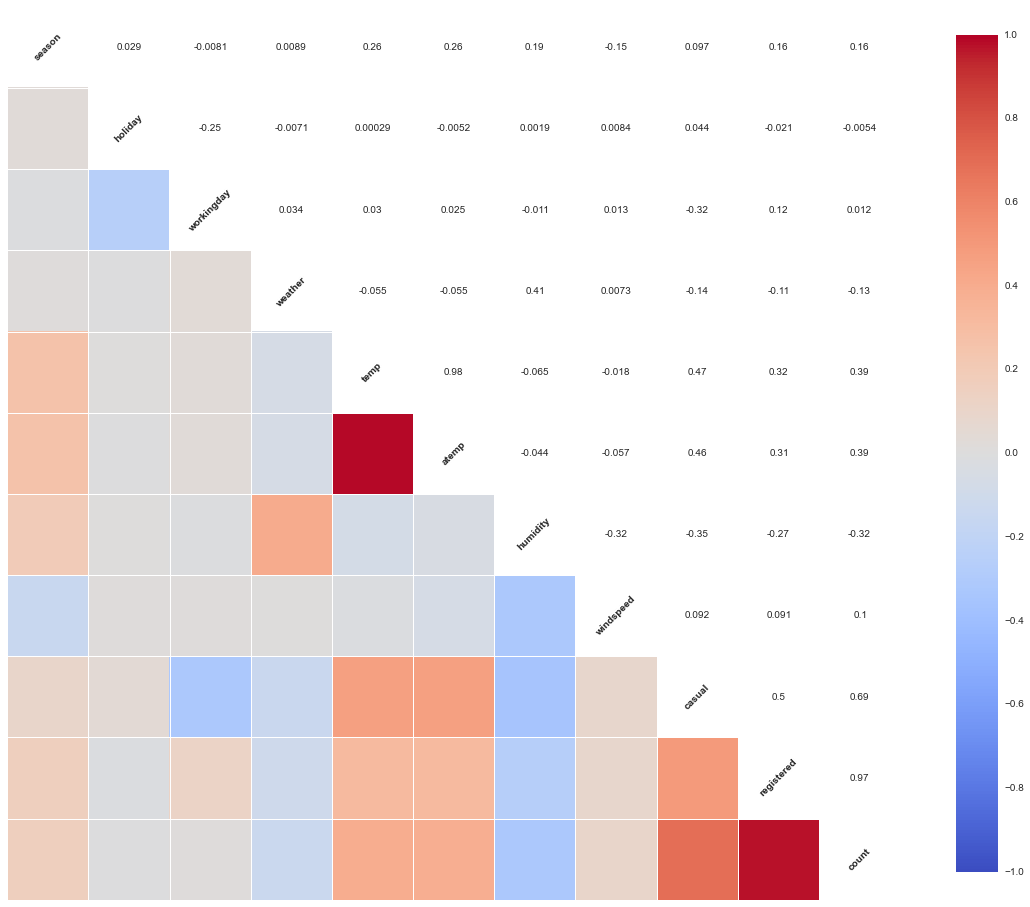

In [7]:
f, ax = plt.subplots(figsize=(20,20))
sns.corrplot(train, sig_stars=False, ax=ax)

1. **count** vs **registered**, **casual** (0.97, 0.69) correlated (it's not big surprise).
2. **count** vs **temp**, **atemp** also correlated, but less (0.39, 0.39).
3. **count** vs **humidity**, **weather** have inverse correlation (-0.32, -0.13).

# 2. Prepare Data
1. Transform target value
2. Detect 0utliers
3. Importance features
4. Feature engineering

## 2.1 Transfort target value

In [8]:
def summary(values, percentiles=[1, 5, 95, 99]):
    for percnetile in percentiles:
        print '{0}th -> {1}'.format(percnetile, np.percentile(values, percnetile) )

def sub_plot(data, column, ax1, ax2):
    data.hist(column, bins=20, ax=ax1)
    data.boxplot(column, ax=ax2)

### Transform count, registered, casual into new log2 column

But we should check that values is more than 0, because `log2(0)` is `minus infinity`.
Recall graph from school:

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/1/17/Binary_logarithm_plot_with_ticks.svg/408px-Binary_logarithm_plot_with_ticks.svg.png" />

In [27]:
for column_name in ['count', 'registered', 'casual']:
    print column_name
    print 'equals to zero', train[ train[column_name] == 0 ][column_name].count()
    print 'less than zero', train[ train[column_name] < 0 ][column_name].count()

count
equals to zero 0
less than zero 0
registered
equals to zero 15
less than zero 0
casual
equals to zero 986
less than zero 0


1. All columns have positive value.
2. For **registered** and **casual** we have cases when value is equals to zero.
3. For solving second point, we can increment all values by one.

In [28]:
train['{0}_log'.format('count')] = train['count'].map(lambda x: np.log2(x) )

for name in ['registered', 'casual']:
    train['{0}_log'.format(name)] = train[name].map(lambda x: np.log2(x+1) )

## 2.2 Detect Outliers

In [12]:
for name in ['count', 'registered', 'casual']:
    print name
    summary(train[name].values, range(1, 10, 1)+ range(90, 100, 1))
    print "\n{0}_log".format(name)
    summary(train["{0}_log".format(name)].values, range(1, 10, 1)+ range(90, 100, 1))
    print

count
1th -> 2.0
2th -> 2.0
3th -> 3.0
4th -> 4.0
5th -> 5.0
6th -> 5.0
7th -> 6.0
8th -> 7.0
9th -> 8.0
90th -> 452.0
91th -> 469.35
92th -> 490.0
93th -> 508.0
94th -> 536.9
95th -> 563.75
96th -> 593.0
97th -> 638.0
98th -> 686.0
99th -> 774.15

count_log
1th -> 1.0
2th -> 1.0
3th -> 1.58496250072
4th -> 2.0
5th -> 2.32192809489
6th -> 2.32192809489
7th -> 2.58496250072
8th -> 2.80735492206
9th -> 3.0
90th -> 8.82017896242
91th -> 8.87451960443
92th -> 8.936637939
93th -> 8.98868468677
94th -> 9.06850936923
95th -> 9.13891129232
96th -> 9.21188829455
97th -> 9.31741261376
98th -> 9.42206476617
99th -> 9.59646916775

registered
1th -> 1.0
2th -> 2.0
3th -> 3.0
4th -> 3.0
5th -> 4.0
6th -> 4.0
7th -> 5.0
8th -> 6.0
9th -> 6.0
90th -> 354.0
91th -> 368.0
92th -> 384.2
93th -> 408.0
94th -> 434.0
95th -> 464.0
96th -> 494.6
97th -> 545.45
98th -> 622.3
99th -> 697.0

registered_log
1th -> 1.0
2th -> 1.58496250072
3th -> 2.0
4th -> 2.0
5th -> 2.32192809489
6th -> 2.32192809489
7th -> 2.5

### Count

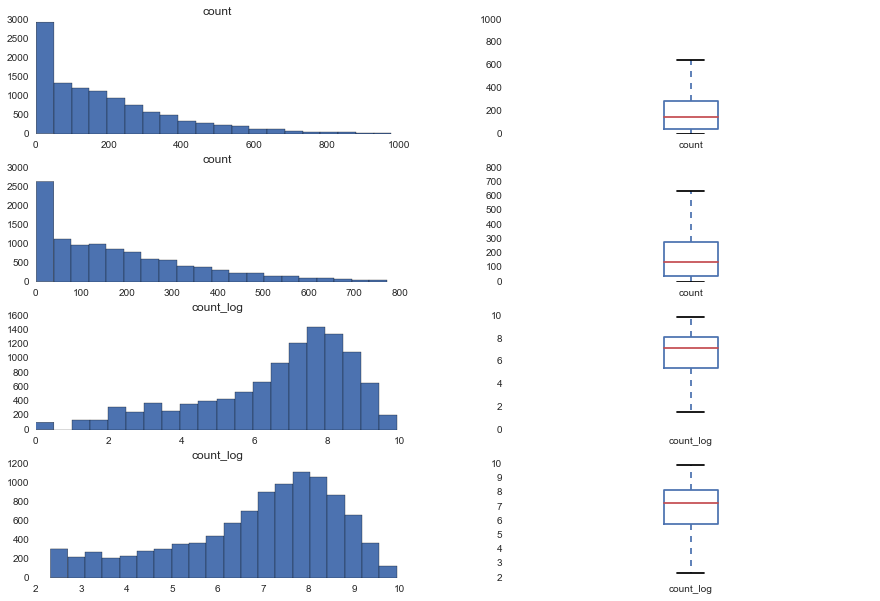

In [14]:
plt.figure(figsize=(500,20))
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8)) = plt.subplots(4,2, figsize=(15, 10))
fig.subplots_adjust(hspace=.8)

sub_plot(train, 'count', ax1, ax2)
sub_plot(train[train['count'] < 774], 'count', ax3, ax4)
sub_plot(train, 'count_log', ax5, ax6)
sub_plot(train[ train.count_log > 2 ], 'count_log', ax7, ax8)

### Registered

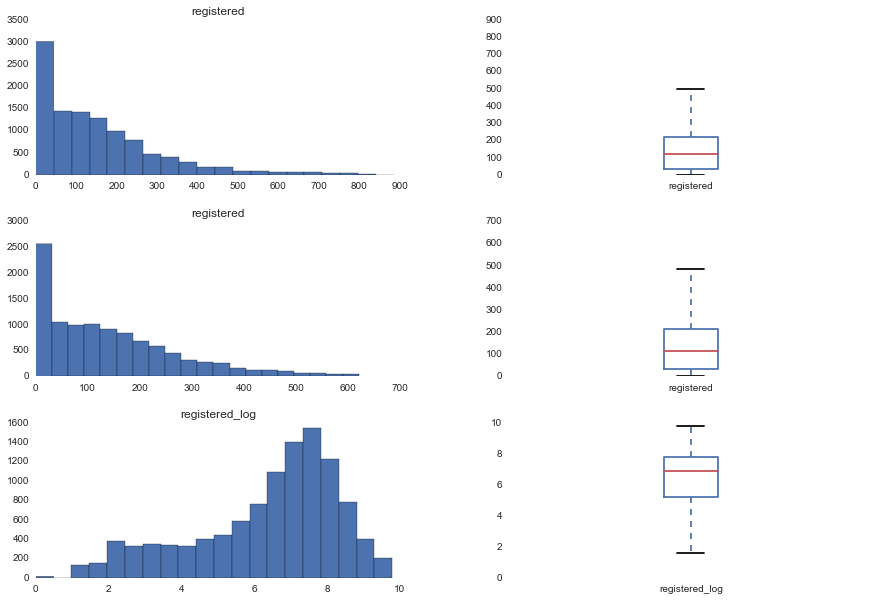

In [29]:
plt.figure(figsize=(500,20))
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3,2, figsize=(15, 10))
fig.subplots_adjust(hspace=.8)

sub_plot(train, 'registered', ax1, ax2)
sub_plot(train[train < 622], 'registered', ax3, ax4)
sub_plot(train, 'registered_log', ax5, ax6)

### Casual

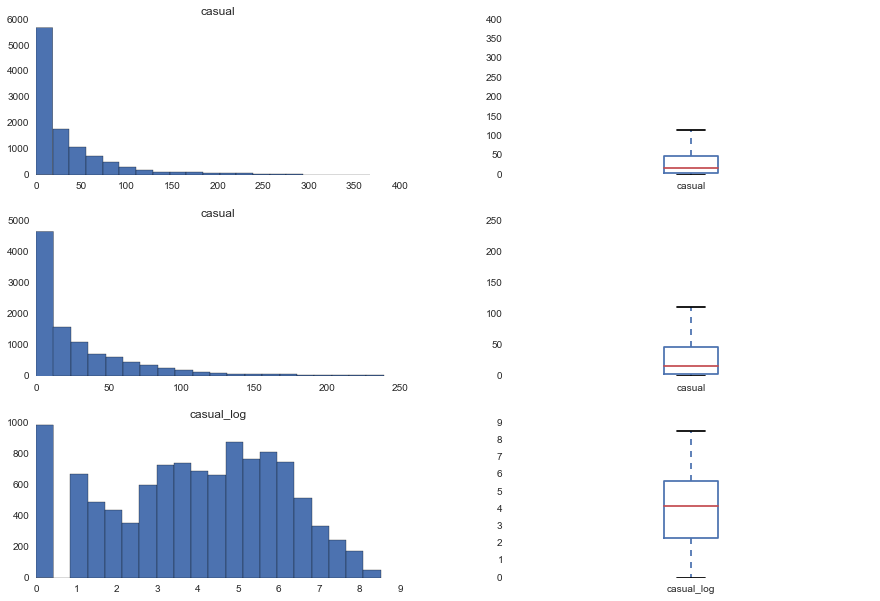

In [30]:
plt.figure(figsize=(500,20))
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3,2, figsize=(15, 10))
fig.subplots_adjust(hspace=.8)

sub_plot(train, 'casual', ax1, ax2)
sub_plot(train[train['casual'] < 240], 'casual', ax3, ax4)
sub_plot(train, 'casual_log', ax5, ax6)

## 2.3 Importances features

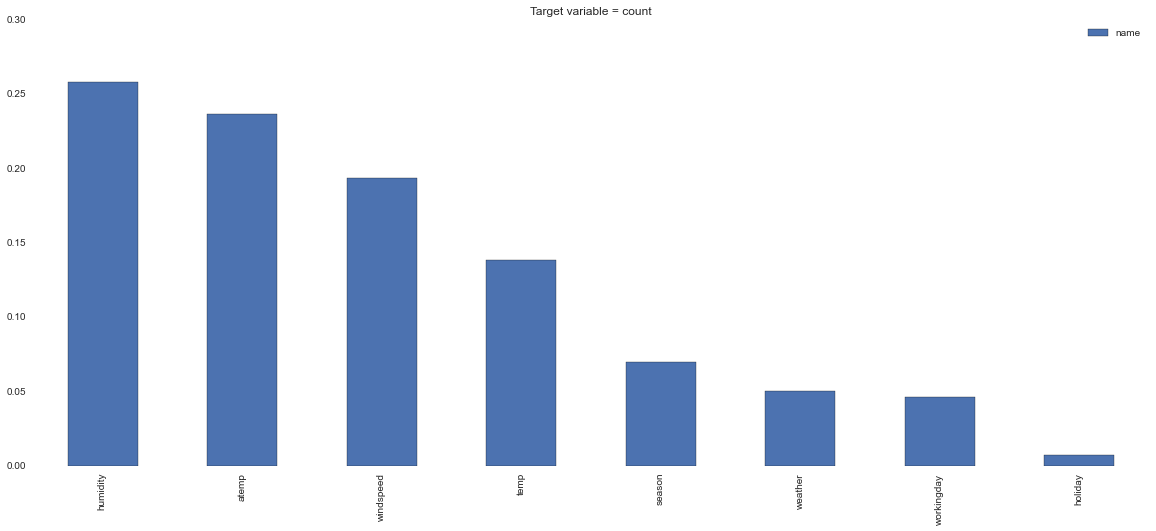

In [17]:
def select_features(data):
    columns = data.loc[ :, (data.dtypes == np.int64) | (data.dtypes == np.float64) | (data.dtypes == np.bool) ].columns.values    
    return [feat for feat in columns if feat not in ['count_log', 'count', 'casual', 'casual_log', 'registered', 'registered_log'] ] 

def get_X_y(data, features=None, target_variable='count'):
    if not features:
        features = select_features(data)
        
    X = data[features].values
    y = data[target_variable].values
    
    return X,y

def get_importance_features(data, model, limit, target_variable):
    X,y = get_X_y(data, target_variable=target_variable)
    cols = select_features(data)
    
    model.fit(X, y)
    feats = pd.DataFrame(model.feature_importances_, index=data[cols].columns)
    feats = feats.sort([0], ascending=False) [:limit]
    return feats.rename(columns={0:'name'})
    
def draw_importance_features(data, model=RandomForestRegressor(), limit=30, target_variable='count'):
    feats = get_importance_features(data, model, limit, target_variable)
    feats.plot(kind='bar', figsize=(20, 8), title="Target variable = {0}".format(target_variable))


draw_importance_features(train, target_variable='count')

Questoins
1. What variable is more important (have bigger influence on `count`)?
2. Is it make sense?

## 2.3 Feature enginnering
Let's try figure out new feature based on exists. Feature **datetime** can be split into few part: **year**, **month**, **day**, **hour**, **minute**, **dayofweek**, **weekend**.

In [83]:
def temp_cat(temp):
    if temp < 15: return 1
    if temp < 25: return 2
    return 3

def cat_hour(hour):
    if 5 >= hour < 10:
        return 1#morning
    elif 10 >= hour < 17:
        return 2#day
    elif 17 >= hour < 23:
        return 3 #evening
    else:
        return 4 #night

def etl_datetime(df):
    df['datetime'] = pd.to_datetime( df['datetime'] )
    
    df['year'] = df['datetime'].map(lambda x: x.year)
    df['month'] = df['datetime'].map(lambda x: x.month)
    df['day'] = df['datetime'].map(lambda x: x.day)
    df['hour'] = df['datetime'].map(lambda x: x.hour)
    df['minute'] = df['datetime'].map(lambda x: x.minute)
    df['dayofweek'] = df['datetime'].map(lambda x: x.dayofweek)
    df['weekend'] = df['datetime'].map(lambda x: x.dayofweek in [5,6])
    df['time_of_day'] = df['hour'].map(cat_hour)
    
etl_datetime(train)
#etl_datetime(test)

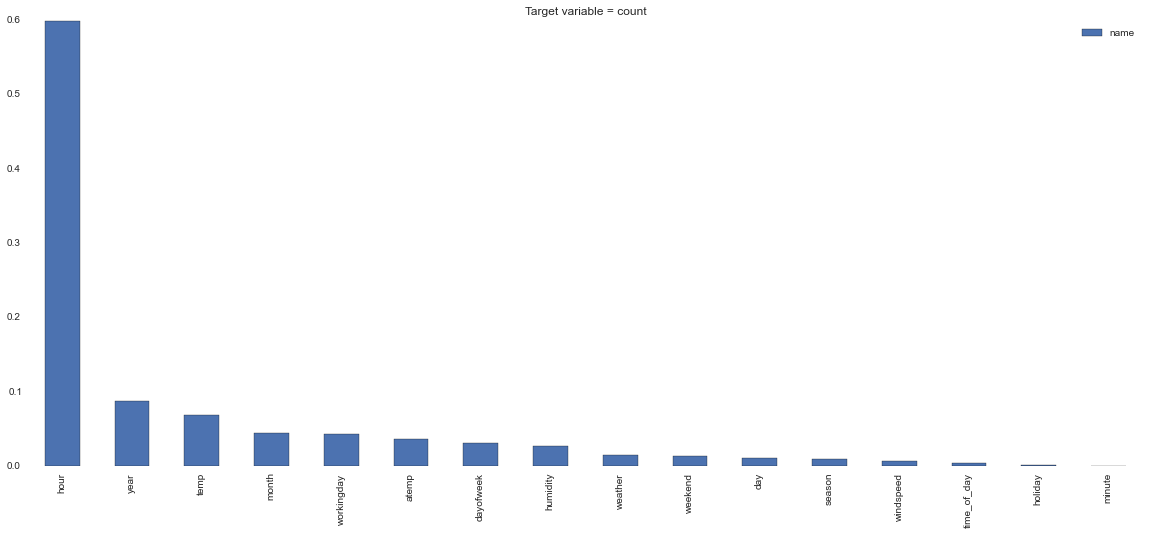

In [20]:
draw_importance_features(train)

Questions
1. What is changes?
2. Does it make sense?

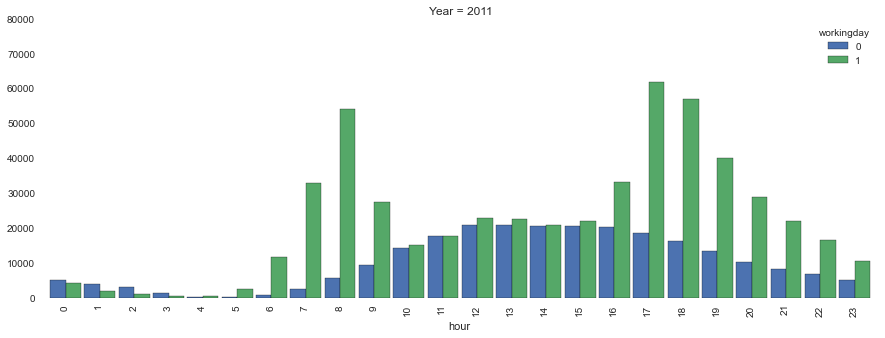

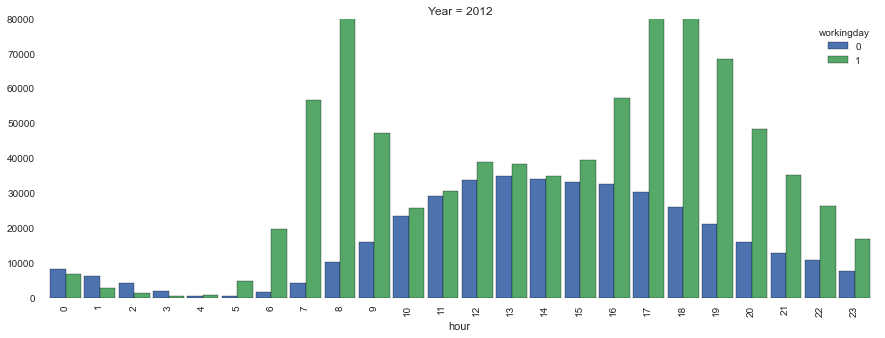

In [21]:
def plot_by_hour(data, year=None, agg='sum'):
    dd = data
    if year:
        dd = dd[ dd.year == year ]
        
    by_hour = dd.groupby(['hour', 'workingday'])['count'].agg(agg).unstack()
    return by_hour.plot(kind='bar', ylim=(0, 80000), figsize=(15,5), width=0.9, title="Year = {0}".format(year))


plot_by_hour(train, year=2011)
plot_by_hour(train, year=2012)

1. On working day we have few spikes at 7,8,9 (going to work) and 17,18,19 (return to home).
2. On non working day looks more smoothing (without any spikes).
3. In the middle hours (from 10 to 15) count of rent looks simmilar.
4. On working day count of rent greater than non-working day.
5. A little greater count of rent at the night in non-working day.

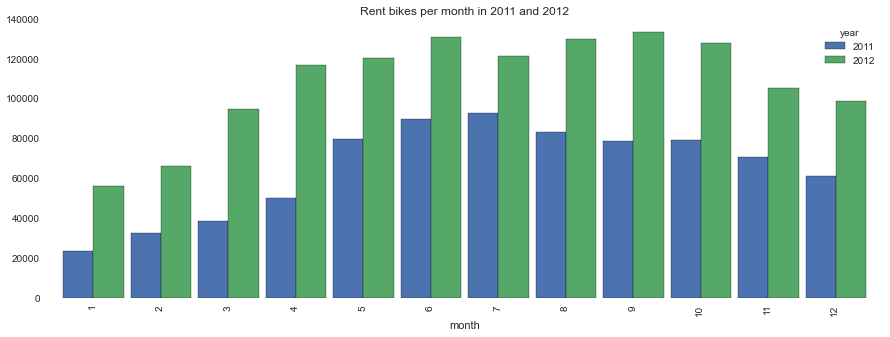

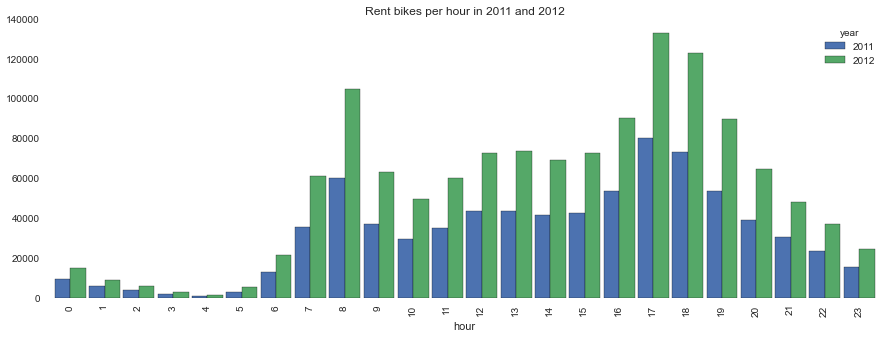

In [22]:
def plot_by_year(agg_attr, title):
    by_year = train.groupby([agg_attr, 'year'])['count'].agg('sum').unstack()
    return by_year.plot(kind='bar', figsize=(15,5), width=0.9, title=title)


plot_by_year('month', "Rent bikes per month in 2011 and 2012")
plot_by_year('hour', "Rent bikes per hour in 2011 and 2012")

Questinos
1. what you can about difference between 2011 and 2012?

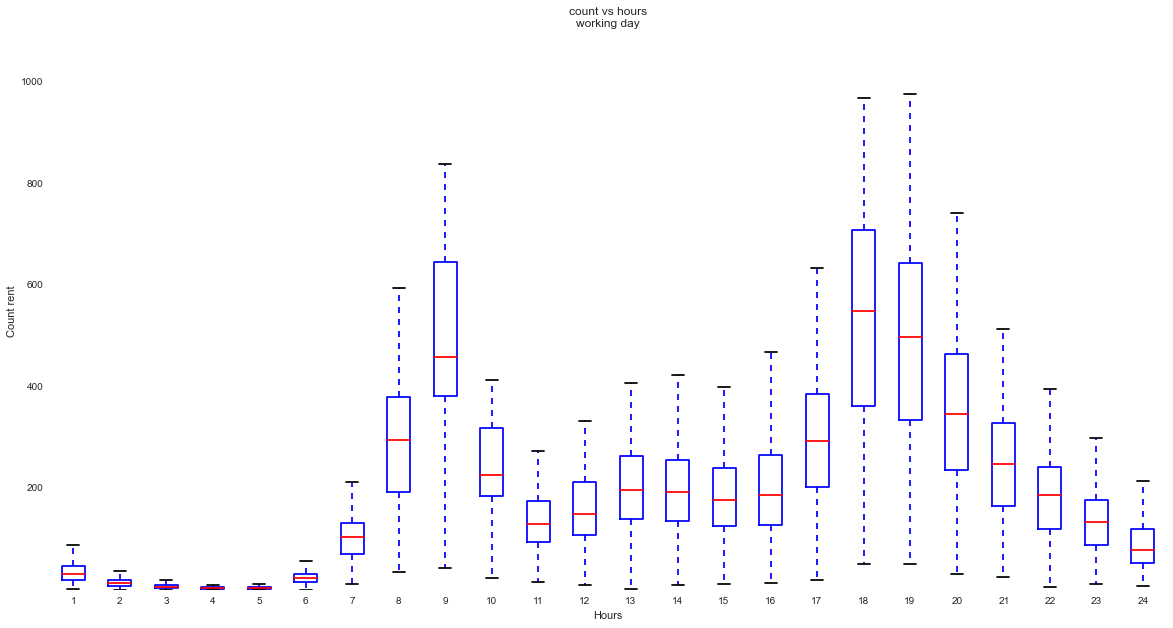

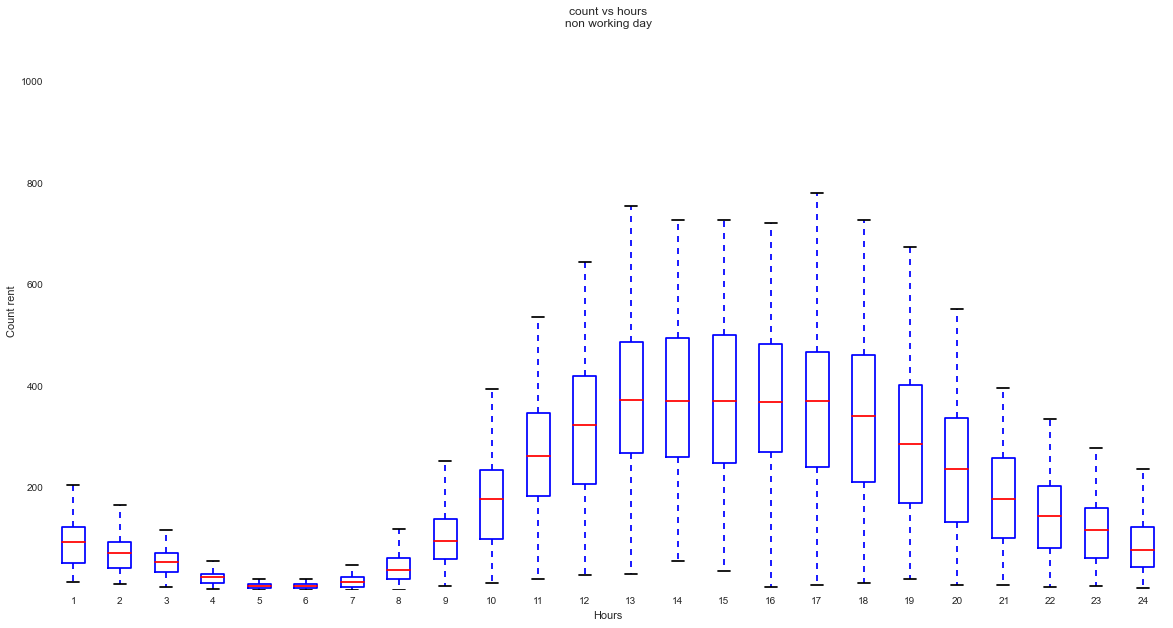

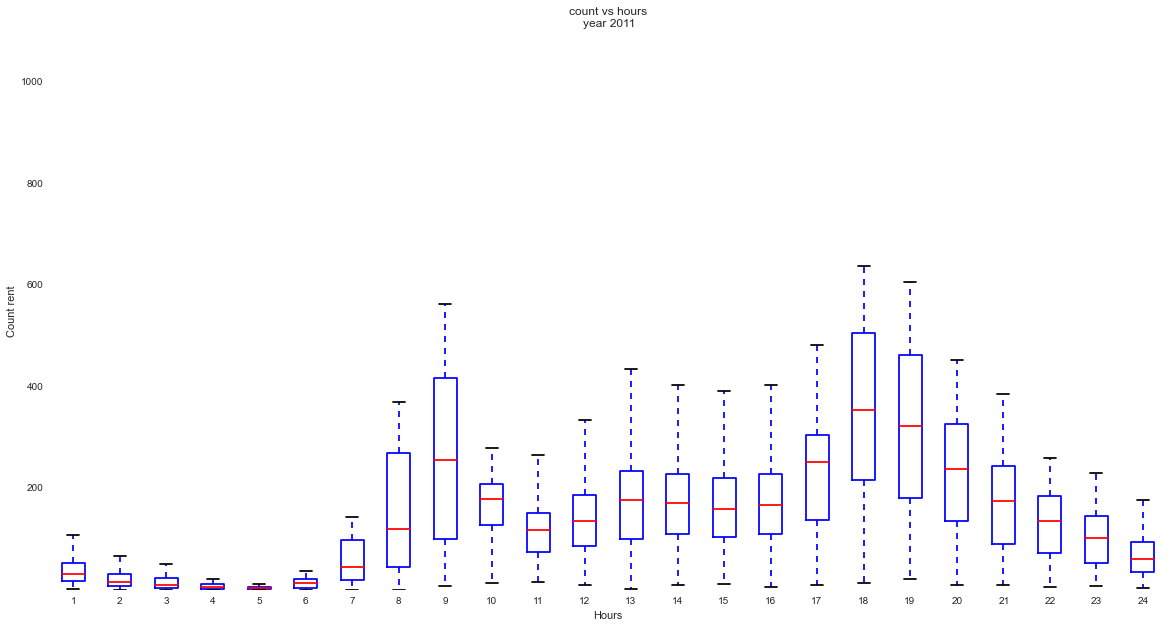

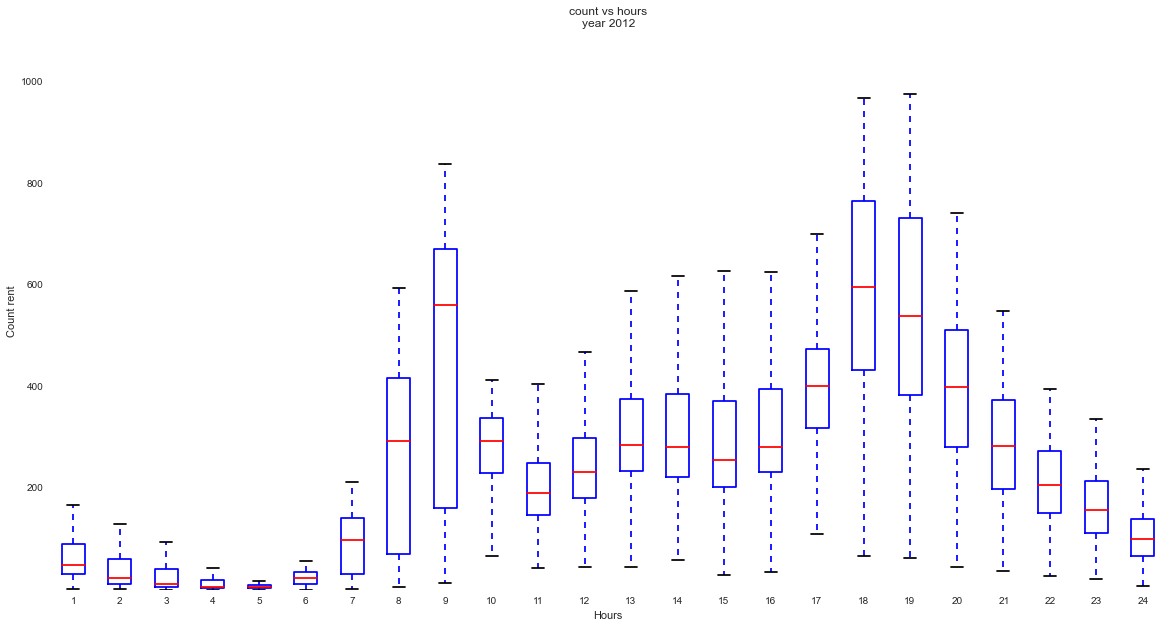

In [23]:
def plot_hours(data, message = ''):
    hours = {}
    for hour in range(24):
        hours[hour] = data[ data.hour == hour ]['count'].values

    plt.figure(figsize=(20,10))
    plt.ylabel("Count rent")
    plt.xlabel("Hours")
    plt.title("count vs hours\n" + message)
    plt.boxplot( [hours[hour] for hour in range(24)] )
    
    axis = plt.gca()
    axis.set_ylim([1, 1100])
    

plot_hours( train[train.workingday == 1], 'working day')
plot_hours( train[train.workingday == 0], 'non working day')

plot_hours( train[train.year == 2011], 'year 2011')
plot_hours( train[train.year == 2012], 'year 2012')

1. The biggest variance for working day is at 8,9 and 18,19,20.
2. The biggest variance for non-working day is from 12 to 20.

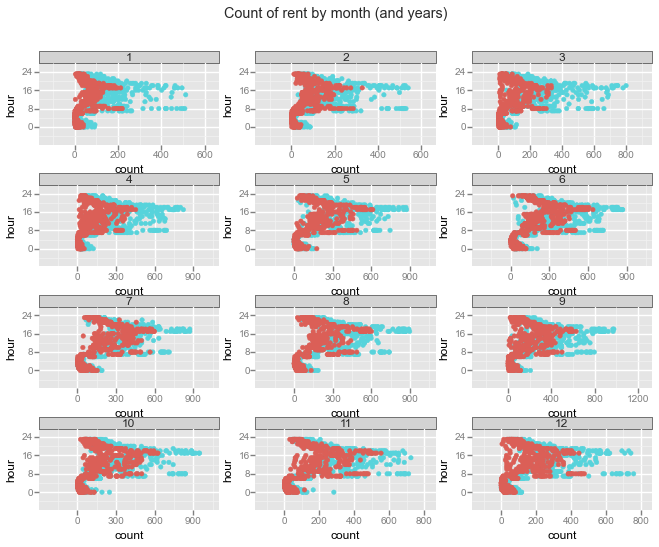

<ggplot: (297866157)>

In [24]:
ggplot(aes(x='count', y='hour', color='year'), train) + facet_wrap('month') + geom_point()\
    + ggtitle('Count of rent by month (and years)') 

Questions:
1. what do you see on the scatter plots?

### Generate a new feature

In [25]:
def get_num_features(data):
    columns = data.loc[ :, (data.dtypes == np.float) |  (data.dtypes == np.int64) ].columns.values
    
    return [c for c in columns if 'count' not in c and 'registered' not in c and 'casual' not in c]

def generate_new_features(data):
    num_cols = get_num_features(data)
    for feat_x, feat_y in itertools.product(num_cols, num_cols):
        name = '{0}_x_{1}'.format( feat_x,feat_y )
        data[name] =  data[feat_x] * data[feat_y]
        

generate_new_features(train)
#generate_new_features(test)

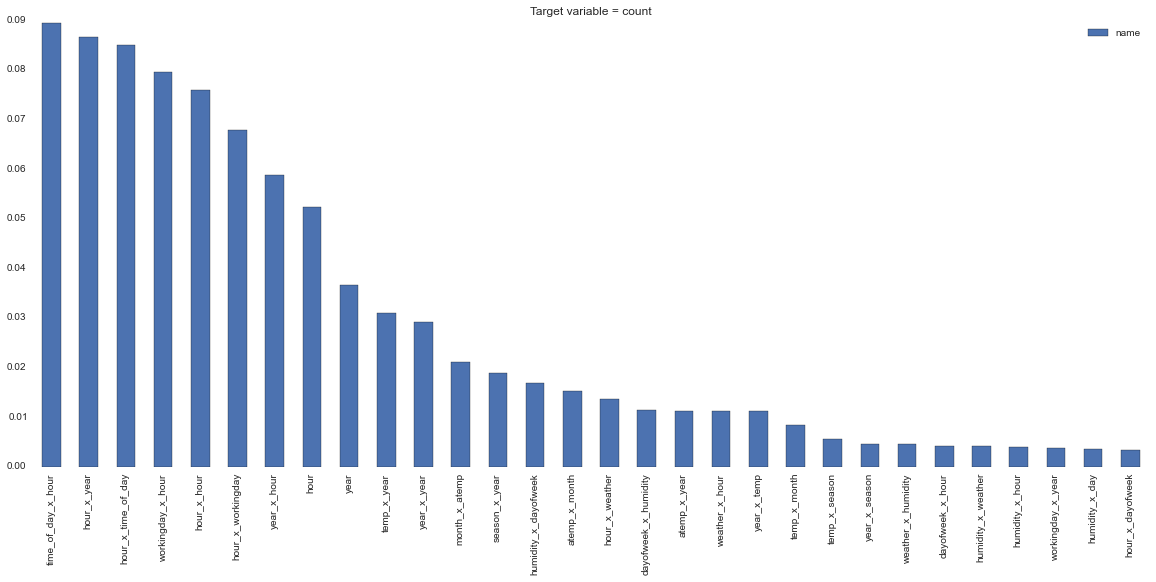

In [26]:
draw_importance_features(train)

# 3. Modeling and Evaluation
1. Preapre quality function
2. Prepare training set and validate set
3. Single variable model (base line)
4. Two variable model
5. Using more advanced models
6. Analyze models
7. Ensemble
8. Tuning hyperparameters
9. Combine results into one the best :)

## 3.1 Quality function

$$ \sqrt{\frac{1}{n} \sum_{i=1}^n (\log(p_i + 1) - \log(a_i+1))^2 }$$

where  
**n** is the number of hours in the test set  
**pi** is your predicted count  
**ai** is the actual count  
**log(x)** is the natural logarithm  

In [35]:
def rmsle(y_true, y_pred):
    diff = np.log(y_pred + 1) - np.log(y_true + 1)
    mean_error = np.square(diff).mean()
    return np.sqrt(mean_error)

scorer = make_scorer(rmsle, greater_is_better=False)

## 3.2 Train and test sets


Let's check distribution by days in train set.

In [36]:
train.day.unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19])

In [80]:
def train_test_split(data, last_training_day=0.3):
    days = train.day.unique()
    shuffle(days)
    test_days = days[: len(days) * 0.3]
    
    data['is_test'] = data.day.isin(test_days)
    df_train = data[data.is_test == False] 
    df_test  = data[data.is_test == True]
    
    return df_train, df_test

## Check quality model
General solution for checking quality all models which we'll have.

In [81]:
def apply_model(model, X_train, X_test, y_train):
    model.fit(X_train, y_train)
    return model.predict(X_test)

def quality_model(y_test, y_pred):
    return rmsle(y_test, y_pred)

### Train & Test set

In [84]:
df_train, df_test = train_test_split(train)

features = [feature for feature in train.columns if feature not in ['datetime', 'count', 'count_log', 'registered', 'registered_log', 'casual', 'casual_log', 'is_test']]

X_train  = df_train[features].values
X_test   = df_test[features].values

y_train_count   = df_train['count'].values
y_test_count    = df_test['count'].values

y_train_count_log   = df_train['count_log'].values
y_test_count_log    = df_test['count_log'].values

y_train_registered   = df_train['registered'].values
y_train_casual       = df_train['casual'].values

y_train_registered_log   = df_train['registered_log'].values
y_train_casual_log       = df_train['casual_log'].values

models_result = {}

## 3.3 Single variable model

In [85]:
class SingleVariableModel(BaseEstimator, ClassifierMixin):
    def __init__(self, features, df_train, agg_fun=np.mean, target_column='count'):
        self.features = features
        self.df_train = df_train
        self.agg_fun = agg_fun
        self.target_column = target_column
        
    def pre_calc(self):
        self.single_var = df_train.groupby('hour').agg(self.agg_fun)[self.target_column].reset_index().to_dict()[self.target_column]
        
    def fit(self, X, y):
        self.pre_calc()
        return self
        
    def predict(self, X):
        hour_idx = self.features.index('hour')
        result = []

        for row in X:
            result.append( self.single_var[ int(row[hour_idx]) ] )
        return np.array(result)
    
    def __repr__(self):
        return 'SingleVariableModel: {0} {1}'.format(agg_fun.__name__, target_column)


for target_column in ['count', 'count_log']:
    print target_column
    for agg_fun in [np.mean, np.median]:
        model = SingleVariableModel(features, df_train, agg_fun, target_column)
        y_pred = apply_model(model, X_train, X_test, y_train_count)
        if target_column == 'count_log':
            y_pred = np.exp2(y_pred)
        
        quality = quality_model(y_test_count, y_pred)
        models_result[ ('single_variable', model, target_column) ] = quality
        print "{0}: {1}".format(agg_fun.__name__, quality)
    print

count
mean: 0.810921642868
median: 0.785715502558

count_log
mean: 0.765709480267
median: 0.785715349321



## 3.4 Two variable model
We'll use `hour` and `year`.

In [86]:
class TwoVariableModel(BaseEstimator, ClassifierMixin):
    def __init__(self, features, df_train, agg_fun=np.mean, target_column='count'):
        self.features = features
        self.df_train = df_train
        self.agg_fun = agg_fun
        self.target_column = target_column
    
    def pre_calc(self):
        agg_hour_year = df_train.groupby(['hour', 'year']).agg(self.agg_fun)[self.target_column].reset_index().to_dict()
        self.two_var = {}
        for hour, target_value, year in zip(agg_hour_year['hour'].values(), agg_hour_year[self.target_column].values(), agg_hour_year['year'].values()):
            self.two_var[(year, hour)] = target_value
    
    def fit(self, X, y):
        self.pre_calc()
        return self
        
    def predict(self, X):
        hour_idx = self.features.index('hour')
        year_idx = self.features.index('year')
        result = []

        for row in X:
            year = int(row[year_idx])
            hour = int(row[hour_idx])
            result.append( self.two_var[(year, hour)] )
            
        return np.array(result)

    def __repr__(self):
        return 'TwoVariableModel: {0} {1}'.format(agg_fun.__name__, target_column)


for target_column in ['count', 'count_log']:
    print target_column
    for agg_fun in [np.mean, np.median]:
        model = TwoVariableModel(features, df_train, agg_fun, target_column)
        y_pred = apply_model(model, X_train, X_test, y_train_count)
        if target_column == 'count_log':
            y_pred = np.exp2(y_pred)
            
        quality = quality_model(y_test_count, y_pred)
        models_result[ ('two_variable', model, target_column) ] = quality
        print "{0}: {1}".format(agg_fun.__name__, quality)     
    print

count
mean: 0.753107156295
median: 0.725492120087

count_log
mean: 0.710406561118
median: 0.725491294426



## 3.5 More advanced models

In [87]:
def default_models():
    yield ('extra_tree', ExtraTreesRegressor)
    yield ('random_forest', RandomForestRegressor)
    yield ('bagging', BaggingRegressor)
    yield ('dec_tree', DecisionTreeRegressor)

### 3.5.1 Count

In [88]:
for name, model_class in default_models():
    model = model_class()
    y_pred = apply_model(model, X_train, X_test, y_train_count)
    quality = quality_model(y_test_count, y_pred)
    models_result[ (name, model, 'count') ] = quality
    print '{0}: {1}'.format(name, quality)

extra_tree: 0.00489841134119
random_forest: 0.000561886157941
bagging: 0.000620149741682
dec_tree: 0.000517383775069


### 3.5.2 Count log

In [89]:
for name, model_class in default_models():
    model = model_class()
    y_pred_log2 = apply_model(model, X_train, X_test, y_train_count_log)
    quality = quality_model(y_test_count, np.exp2(y_pred_log2) )
    models_result[ (name, model, 'count_log') ] = quality
    print '{0}: {1}'.format(name, quality)

extra_tree: 0.0221161907981
random_forest: 0.000705781842452
bagging: 0.000514198023842
dec_tree: 0.000530077420675


### 3.5.3 Registered + Casual

In [90]:
for name, model_class in default_models():
    model_register, model_casual = model_class(), model_class()
    y_pred_register = apply_model(model_register, X_train, X_test, y_train_registered)
    y_pred_casual = apply_model(model_casual, X_train, X_test, y_train_casual)
    y_pred = (y_pred_register + y_pred_casual)

    
    quality = quality_model(y_test_count, y_pred )
    models_result[ (name, (model_register, model_casual), 'registered_casual') ] = quality
    print '{0}: {1}'.format(name, quality)

extra_tree: 0.0487803516599
random_forest: 0.0501737403163
bagging: 0.0502619092672
dec_tree: 0.136570412621


### 3.5.4 Registered log + Casual log

In [91]:
for name, model_class in default_models():
    model_register, model_casual = model_class(), model_class()
    y_pred_register_log = apply_model(model_register, X_train, X_test, y_train_registered_log)
    y_pred_casual_log = apply_model(model_casual, X_train, X_test, y_train_casual_log)
    y_pred = (np.exp2(y_pred_register_log)-1) + (np.exp2(y_pred_casual_log)-1)

    
    quality = quality_model(y_test_count, y_pred )
    models_result[ (name, (model_register, model_casual), 'registered_casual_log') ] = quality
    print '{0}: {1}'.format(name, quality)

extra_tree: nan
random_forest: nan


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

## 3.6 Analyze models
Which one predict too close the true value?

In [57]:
y_pred_by_model = {
    'count': y_test_count
}
for model_item in models_result:
    if 'registered_casual' in model_item[2]:
        model_register, model_casual = model_item[1]
        y_pred_register = model_register.predict(X_test)
        y_pred_casual = model_register.predict(X_test)
        
        if '_log' in model_item[2]:
            y_pred = (np.exp2(y_pred_register)-1) + (np.exp2(y_pred_casual)-1)
        else:
            y_pred = y_pred_register + y_pred_casual
        
    else:
        y_pred = model.predict(X_test)
        
        if '_log' in model_item[2]:
            y_pred = np.exp2(y_pred)
            
    key = "{0}_+_{1}".format(model_item[0], model_item[2])
    y_pred_by_model[key] = y_pred

In [58]:
df_pred = pd.DataFrame(y_pred_by_model)
columns_pred = [c for c in df_pred.columns if c != 'count']

def find_winer(row):
    count_value = row['count']
    
    min_col = columns_pred[0]
    min_value = abs(count_value - row[min_col])
    for col in columns_pred[1:]:
        diff = abs(count_value - row[col])
        if diff < min_value:
            min_value = diff
            min_col = col

    return min_col

df_pred['winner'] = df_pred.apply(find_winer, axis=1)
df_pred.groupby('winner').count()['count'].reset_index().sort('count', ascending=False)

,winner,count
1,single_variable_+_count_log,2259
0,single_variable_+_count,599


## 3.7 Ensemble
Combine all result into one.

In [59]:
columns_ensemble = [ c for c in columns_pred ]

df_pred['ensemble_mean'] = df_pred[columns_ensemble].apply(np.mean, axis=1)
df_pred['ensemble_median'] = df_pred[columns_ensemble].apply(np.median, axis=1)

df_pred[ ['ensemble_mean', 'ensemble_median', 'count'] ].head()

for target_column in ['ensemble_mean', 'ensemble_median']:
    print target_column, quality_model(y_test_count, df_pred[target_column].values )

ensemble_mean 0.915752350452
ensemble_median 0.915752350452


## 3.8 Tuning model
Let's try tuning two models: 
- `RandomForestRegressor` 
- `BaggingRegressor` 
- `ExtraTreesRegressor`

In [61]:
def tuning_models():
    rf_params = {
        'n_estimators': [100, 200], 
        'min_samples_split': [5, 15, 20], 
        'n_jobs': [-1],
        'min_samples_leaf': [1, 2]
    }
s
    bagging_params = {
        'n_estimators': [100, 150, 170, 180, 200],
        'n_jobs': [-1],
    }

    extratree_params = {
        'n_estimators': [50, 100, 150],
        'min_samples_leaf': [1, 2],
        'min_samples_split': [2, 5, 7],
        'n_jobs': [-1],
    }

    yield (extratree_params, 'extra_tree', ExtraTreesRegressor)
    yield (rf_params, 'random_forest', RandomForestRegressor)
    yield (bagging_params, 'bagging', BaggingRegressor)

In [ ]:
for params_model, name, model_class in tuning_models():
    print name
    for params in ParameterGrid(params_model):
        model_register, model_casual = model_class(), model_class()
        model_register.set_params(**params)
        model_casual.set_params(**params)
        
        y_pred_register_log = apply_model(model_register, X_train, X_test, y_train_registered_log)
        y_pred_casual_log = apply_model(model_casual, X_train, X_test, y_train_casual_log)
        y_pred = (np.exp2(y_pred_register_log)-1) + (np.exp2(y_pred_casual_log)-1)
        
        quality = quality_model(y_test_count, y_pred )
        models_result[ (name, (model_register, model_casual), 'registered_casual_log', str(params)) ] = quality
        print '{0}: {1} {2}'.format(name, quality, params)

## 3.9 Combine results into one the best :)

In [62]:
#...